# Nonlinear Elasticity in a multipatch domain


In [1]:
%pylab inline
import scipy
import itertools

from pyiga import bspline, assemble, vform, geometry, vis, solvers

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

# assemble matrix
from scipy.sparse import coo_matrix, block_diag, bmat

# line search
from scipy.optimize import line_search

from geo_annulus import *
#from multipatch_block_handler import *
from plots import *
from ass_nonlin_el import *
from solver import *
from line_search import *


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
 no MKL


In [2]:
# 3 D #
p = 3 # spline degree
multi= 1
n_el = (12, 3, 6)  # number of elements in x, y, z direction, isotropic material
# displacement space: degree p,   continuity p-1
kvs_u = tuple(bspline.make_knots(p, 0.0, 1.0, n, mult=multi) for n in n_el) # or : mult=2
m_u = tuple(kv.numdofs for kv in kvs_u)


In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.collections import LineCollection
from mpl_toolkits import mplot3d

def plot_geo(geo, grid=10, gridx=None, gridy=None, gridz= None,
             res=30,
             linewidth=None, color='black',  **kwargs):
    """Plot a wireframe representation of a 2D geometry."""
    #fig = plt.figure()
    
    if geo.sdim == 1 and geo.dim == 2:
        print("plot_curve")
        return plot_curve(geo, res=res, linewidth=linewidth, color=color)
    
    #print("geo.sdim:", geo.sdim)
    #print("geo.dim:", geo.dim)
    
    if geo.dim == geo.sdim == 2:
        #assert geo.dim == geo.sdim == 2, 'Can only plot 2D geometries'
        if gridx is None: gridx = grid
        if gridy is None: gridy = grid
        supp = geo.support

        # if gridx/gridy is not an array, build an array with given number of ticks
        if np.isscalar(gridx):
            gridx = np.linspace(supp[0][0], supp[0][1], gridx)
        if np.isscalar(gridy):
            gridy = np.linspace(supp[1][0], supp[1][1], gridy)

        meshx = np.linspace(supp[0][0], supp[0][1], res)
        meshy = np.linspace(supp[1][0], supp[1][1], res)

        def plotline(pts, capstyle='butt'):
            plt.plot(pts[:, 0], pts[:, 1], color=color, linewidth=linewidth,
                     solid_joinstyle='round', solid_capstyle=capstyle)

        pts = grid_eval(geo, (gridx, meshy))
        plotline(pts[0, :, :], capstyle='round')
        for i in range(1, pts.shape[0] - 1):
            plotline(pts[i, :, :])
        plotline(pts[-1, :, :], capstyle='round')

        pts = grid_eval(geo, (meshx, gridy))
        plotline(pts[:, 0, :], capstyle='round')
        for j in range(1, pts.shape[1] - 1):
            plotline(pts[:, j, :])
        plotline(pts[:, -1, :], capstyle='round')

    
    if geo.sdim == geo.dim == 3:
        #print("3D geometry")
        # syntax for 3-D projection
        #ax = plt.axes(projection ='3d')
        #assert geo.dim == geo.sdim == 3, 'Can only plot 3D geometries'
        
        if gridx is None: gridx = grid
        if gridy is None: gridy = grid
        if gridz is None: gridz = grid
        supp = geo.support
        
        # if gridx/gridy is not an array, build an array with given number of ticks
        if np.isscalar(gridx):
            gridx = np.linspace(supp[0][0], supp[0][1], gridx)
            #print(gridx)
        if np.isscalar(gridy):
            gridy = np.linspace(supp[1][0], supp[1][1], gridy)
        if np.isscalar(gridz):
            gridz = np.linspace(supp[2][0], supp[2][1], gridz)

        meshx = np.linspace(supp[0][0], supp[0][1], res)
        #print(meshx)
        meshy = np.linspace(supp[1][0], supp[1][1], res)
        meshz = np.linspace(supp[2][0], supp[2][1], res)

        def plotline(pts, capstyle='butt'):
            ax.plot_surface(pts[..., 0], pts[..., 1], pts[..., 2], cmap=cm.coolwarm, linewidth=linewidth,  **kwargs)

        pts = grid_eval(geo, (gridx, meshy, meshz))# meshy
        plotline(pts[0, :, :], capstyle='round')# beginning
        for i in range(1, pts.shape[0] - 1): 
            plotline(pts[i, :, :]) # inbetween
        plotline(pts[-1, :, :], capstyle='round') # end

        pts = grid_eval(geo, (meshx, gridy, meshz))
        plotline(pts[:, 0, :], capstyle='round')
        for j in range(1, pts.shape[1] - 1):
            plotline(pts[:, j, :])
        plotline(pts[:, -1, :], capstyle='round')

        pts = grid_eval(geo, (meshx, meshy, gridz))
        plotline(pts[:, :, 0], capstyle='round')
        for k in range(1, pts.shape[2] - 1): 
            plotline(pts[:, :, k])
        plotline(pts[:, :, -1], capstyle='round')

        # plotting
        #ax.set_title('3D line plot')
        #plt.show()


In [4]:
# define geometry
# realistic model of an artery: r_inner= 4mm, r_outer= 7mm (preprint)
# human carotid artery: r_i= 3.1 mm, r_o= 4mm (Holzapfel)
r_in = 1.93 #mm
r_out = 2.25 #mm

geos = [
 
    geometry.quarter_annulus(r1=r_in, r2=r_out),
    geometry.quarter_annulus(r1=r_in, r2=r_out).rotate_2d(3*pi/2),
    geometry.quarter_annulus(r1=r_in, r2=r_out).rotate_2d(pi),
    geometry.quarter_annulus(r1=r_in, r2=r_out).rotate_2d(pi/2)
]


# 3D
#geos_3d = [geometry.tensor_product(geometry.line_segment(0,1), g) for g in geos]
geos_3d = [geometry.tensor_product(g, geometry.line_segment(0,5)) for g in geos]

In [5]:
patches_u = [(kvs_u, g) for g in geos_3d] # 3D

# Here we auto-detect the interfaces between the patches.
MP_u = assemble.Multipatch(patches_u, automatch=True) #3D

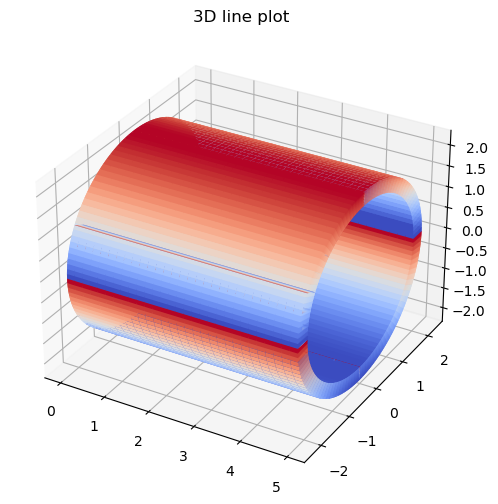

In [6]:
figsize(8,6)
fig = plt.figure()
ax = plt.axes(projection ='3d')

for g in geos_3d:
    plot_geo(g)#, vmin=0, vmax=7.5)

ax.set_title('3D line plot')
plt.show()

In [7]:
# define boundary conditions

In [8]:
# source term f, 3D
def f(x, y, z): return (0.0, 0.0, 0.0)

In [9]:
#Neumann BC
def gN0(x, y, z): 
#quarter annulus in y/z coord.system
    #xx= linspace(0,1,10)
    #for i in range(len(xx)):
    return (0, y/r_in*l_val, z/r_in*l_val) # inner pressure, in normal direction (0, 1, 1)

# quarter annulus in x/y coord.system
   # return (x/r_out*loading_value, y/r_out*loading_value, 0)  #inner  pressure, normalized vector
# normal direction in z does not exist by now!


In [10]:
def g0(x,y,z): #different load over x-axis
    if (x > 1.5).all() and (x < 3.5).all():
        #print(x)
        return l_val # set force at middle only
    else:
        return 0

In [11]:
def gN(x, y, z): #different load over x-axis
    if isinstance(x,numpy.float64):
        return (0, 0, 0)
    s_y = shape(y)
    fac = [g0(xi,y, z) for xi in np.nditer(x)]
    fac= np.reshape(fac, s_y)
    return (0, y/r_in* fac, z/r_in*fac)# inner pressure

In [12]:
# Multipatch objects for all variables (x, y, z)
MP_block = multipatch_block_handler( [MP_u, MP_u, MP_u] ) 

In [13]:
# define Dirichlet boundary function 
def g_zero(x, y, z): return (0.0, 0.0, 0.0) # fixed in y/z, x runs, evtl. set x=x

# set up Dirichlet boundary conditions
bc = MP_block.compute_dirichlet_bcs([
    (1, 'top', g_zero ) # outer bd, 1
])

In [14]:
# Compute solution of nonlinear elasticity problem

In [15]:
# define constant spline functions for integration
kvs_j = tuple(bspline.make_knots(0, 0.0, 1.0, n, mult=multi) for n in n_el) # constant basis vector for integration

In [16]:
M = ass_mass3d(MP_block)
Minv = make_solver(M)

use SuperLU


In [17]:
#incremental loading
maxload =2.666e-3
nsteps= 3
loading= np.linspace(maxload/nsteps, maxload, nsteps)


In [18]:
# No Robin-bdc
robin_data = None

In [19]:
def J(u):
    return ass_energy3d(u, MP_block, kvs_j, neu_data)


def grad_J(u):
    return -ass_rhs3d(u, MP_block, neu_data)


In [20]:
# solve linearized system #Robin instead of Dirichlet, + Neumann force (inner pressure)
### first iteration ###
XP = MP_block.patch_to_global(0) #p=0
dd = shape(XP)[0]

#initial value
u= np.zeros(dd)
solution= []

# set Neumann boundary force (via incremental loading) 

### Linear elasticity for largest loading
l_val = loading[-1] # take last loading value
neu_data = [(0,'bottom',gN0, l_val), (1,'bottom',gN0, l_val), (2,'bottom',gN0, l_val), (3,'bottom',gN0, l_val)] # set neumann

    
### first iteration ###
A, b = ass_nonlinsystem3d(u, MP_block, neu_data) # without Robin-matrix

LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system
rhs= LS.complete(LS.b)
r0 = np.transpose(rhs).dot(Minv.dot(rhs)) #L2-norm
print('Residual0 =', r0)
print('Energy0   =', J(u))

#u_d = make_solver_orig(A, symmetric=True, spd=True).dot(b) 
u_d = make_solver(LS.A).dot(LS.b) 
u_d = LS.complete(u_d)
u += u_d

# new solution
A, b = ass_nonlinsystem3d(u, MP_block, neu_data) # without Robin-matrix
LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system
rhs= LS.complete(LS.b)
r = np.transpose(rhs).dot(Minv.dot(rhs)) #L2-norm
print('Residual  =', r)
print('Energy    =', J(u))
w= np.inner(np.transpose(u_d),rhs)
err = np.sqrt(np.abs(w))
print('Error=', err)

###-----------------###--------------------###
solution = [LS.restrict(u)]
# norm of delta u in first step
normed_du0= np.transpose(u_d).dot(M.dot(u_d)) #L2-norm
###----------------###---------------------###

# print deformation plot (after first iteration)
#get_defplot3d(u, patches_u, kvs_u, MP_u, n_el)

Compiling C:\Users\MHeig\AppData\Local\pyiga\pyiga\Cache\modules\mod96c0e6c6878f70be.pyx because it changed.
[1/1] Cythonizing C:\Users\MHeig\AppData\Local\pyiga\pyiga\Cache\modules\mod96c0e6c6878f70be.pyx


Compiling C:\Users\MHeig\AppData\Local\pyiga\pyiga\Cache\modules\modef493307aa7bf1bb.pyx because it changed.
[1/1] Cythonizing C:\Users\MHeig\AppData\Local\pyiga\pyiga\Cache\modules\modef493307aa7bf1bb.pyx
Residual0 = 0.04279598200667796
Compiling C:\Users\MHeig\AppData\Local\pyiga\pyiga\Cache\modules\mod64fb2c2020b33825.pyx because it changed.
[1/1] Cythonizing C:\Users\MHeig\AppData\Local\pyiga\pyiga\Cache\modules\mod64fb2c2020b33825.pyx
Energy0   = 0.0
use SuperLU
Residual  = 67.8969223744021
Energy    = 0.010577056726368978
Error= 0.3823340934102186


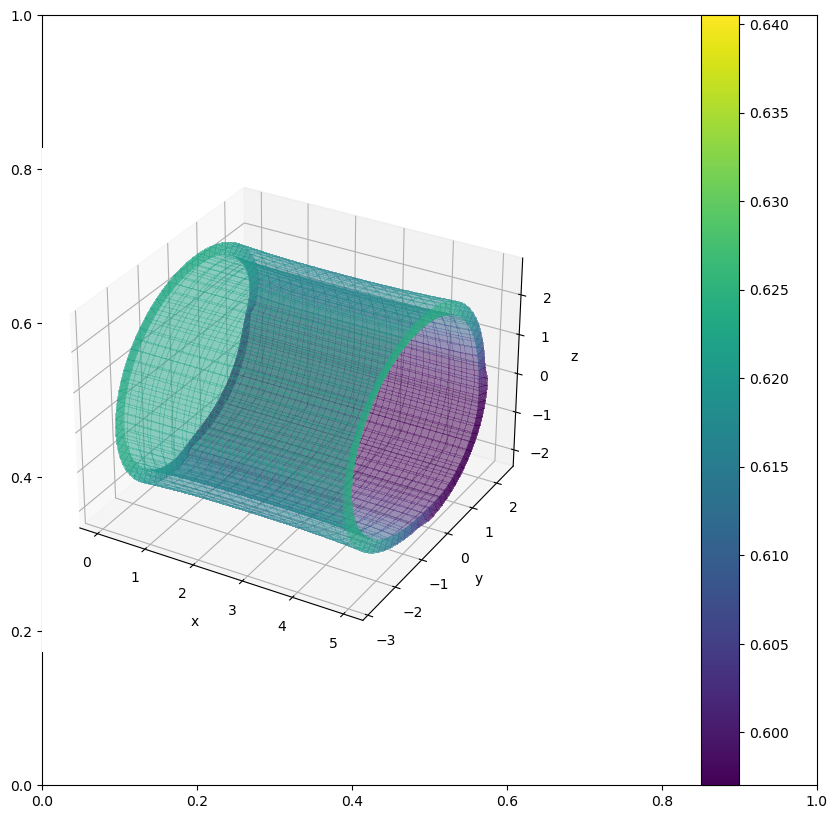

In [23]:
get_defplotC(u, patches_u, kvs_u, MP_u)

In [24]:
def get_defplotpp(u, patches_u, kvs_u, MP_u, grid=2, gridx=None, gridy=None, gridz= None,
             res=20, linewidth=None, **kwargs):
    
    #u= LS.complete(u)
    u1_funcs, u2_funcs, u3_funcs = split_u3d(u, MP_u, kvs_u, patches_u)
    
    fig, ax = plt.subplots(figsize= (10,10))
    #ax = plt.axes(projection ='3d')
    vrange = None
    x_el = n_el[0]
    y_el = n_el[1]
    z_el = n_el[2]
    
    count=0
     # visualization per patch
    for (u1_func, u2_func, u3_func, (kvs, geo)) in zip(u1_funcs, u2_funcs, u3_funcs, patches_u): #u_funcs 
        print('\n patch:', count)
        
        res= x_el

        #if gridx is None: gridx = grid
        #if gridy is None: gridy = grid
        if gridz is None: gridz= 1# grid # = 1# grid
        supp = geo.support
        
        # if gridx/gridy is not an array, build an array with given number of ticks
        #if np.isscalar(gridx):
            #gridx = np.linspace(supp[0][0], supp[0][1], res) # e.g. linespace(0, 1, 10)
        #if np.isscalar(gridy):
            #gridy = np.linspace(supp[1][0], supp[1][1], res)
        if np.isscalar(gridz):
            gridz = np.linspace(supp[2][0], supp[2][1], 1)

        meshx = np.linspace(supp[0][0], supp[0][1], res) # e.g. linespace(0, 1, 50)
        meshy = np.linspace(supp[1][0], supp[1][1], res)
        #meshz = np.linspace(supp[2][0], supp[2][1], res)

        def plotlineC(pts, C, capstyle='butt'):
            #C = np.sqrt(np.power(pts[..., 1], 2) + np.power(pts[..., 2],2))
            #print(shape(C))
            vrange = (C.min(), C.max())
            #vrange = (0, 1.5e-5)
            print(shape(pts))
            
            plt.pcolormesh(pts[..., 1], pts[..., 2], C, shading='gouraud', cmap='viridis', 
                                    vmin=vrange[0], vmax=vrange[1])
            
            plt.plot(pts[0,0, 1], pts[0,0, 2], 'ro') # inner radius
            plt.plot(pts[0,res-1, 1], pts[0,res-1, 2], 'bo') # outer radius
            radius_inner = np.sqrt( (pts[0,0, 1])**2 + (pts[0,0, 2])**2)
            print('inner_radius: ', radius_inner)
            #plt.plot(pts[z_el-1,0, 1], pts[z_el-1,0, 2], 'bo') # inner radius
            #ax.plot_surface(pts[..., 0], pts[..., 1], pts[..., 2], linewidth=0, antialiased=False, shade = False, alpha = 0.3,facecolors=cm.viridis(C), vmin=vrange[0], vmax=vrange[1])
            #ax.plot_wireframe(pts[..., 0], pts[..., 1], pts[..., 2], linewidth=1, color='grey') # grid
            #ax.plot_surface(pts[..., 0], pts[..., 1], pts[..., 2], facecolors=colors, linewidth=0) # checkerboard
        
        #xgridyz = (gridx,gridx, gridx)
        #ygridxz = (meshx, gridy, meshz)
        zgridxy = (meshx, meshy, gridz)


         # z-grid
        dis1 = u1_func.grid_eval(zgridxy) #x-value evaluated on 3-dim grid
        dis2 = u2_func.grid_eval(zgridxy) #y-value
        dis3 = u3_func.grid_eval(zgridxy) #z-value
        dis = np.stack((dis1,dis2, dis3), axis=-1) # displacement evaluated on 3-dim grid   
        print('dis=',shape(dis))
        #print('dis3=', shape(dis3))
        print('displacement_inner= {}'.format(dis[0, 0,...]))
        #print('displacement_y= {}'.format(dis[...,1]))
        #print('displacement_21= {}'.format(dis2[...,0]))
        dis23= np.stack((dis2[...,0], dis3[...,0]), axis=-1) # displacement(y,z) evaluated on 3-dim grid, reduced to 2d 
        #print('displacement_23= {}'.format(dis23))
        #print('first: ',dis23[0,0, 0])#inner y
        #print('second: ',dis23[0,0, 1])# innerz
        #print('first2: ',dis23[0,res-1, 0])# outer y
        #print('second2: ',dis23[0,res-1, 1])# outer z
        #print('displacement_z= {}'.format(dis[...,2]))
        #print('displacement_inner= {}'.format(dis[0,0,0]))
        #print('displacement_inner= {}'.format(dis))
        #print('displacement_outer= {}'.format(dis[0, res-1,...]))
        #print('displacement_outer= {}'.format(dis[0,0,0]))
         #plt.plot(G[i, 0, 0] + dis[0,0, 0], G[i, 0, 1] + dis2[i, 0], 'ro') # inner radius
        

        pts = grid_eval(geo, zgridxy) + dis # # + displacement z-coord
        C = np.sqrt(np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))
        #vrange = (C.min(), C.max())
        #norm = mpl.colors.Normalize(vmin=vrange[0], vmax=vrange[1])
       
        
        plotlineC(pts[:, :, 0],C[:, :, 0])
        for k in range(1, pts.shape[2] - 1): 
            plotlineC(pts[:, :, k], C[:, :, k])
        plotlineC(pts[:, :, -1], C[:, :, -1])
        
             
        G= grid_eval(geo, zgridxy)
        print('G=',shape(G))
        #print(G)
        G23= np.stack((G[...,1], G[...,2]), axis=-1) # displacement(y,z) evaluated on 3-dim grid, reduced to 2d 
        #print(G23)
        #print(shape(G23))
        #print('firstG:', G23[0,0,0,0])
        #print('secondG:', G23[0,0,0,1])
        #print('firstG3:', G[0,0,0, 1])
        #print('secondG3:', G[0,0,0, 2])
        
        #print('first2G:', G23[0,res-1,0,0])
        #print('second2G:', G23[0,res-1,0,1])
        plt.plot(G[0,0,0, 1], G[0,0,0, 2], 'mo') # inner radius
        plt.plot(G[0,res-1,0, 1], G[0,res-1,0, 2], 'go') # outer radius
        #plt.plot(G[0,0,0, 1] +dis2[0,0,0], G[0,0,0, 2]+dis3[0,0,0], 'mo') # inner radius
        #plt.plot(G[0,res-1,0, 1]+dis2[0,0,0], G[0,res-1,0, 2]+dis3[0,0,0], 'go') # outer radius
        
        ### need for data export!!
        #print( 'dis_inner_y/dis_outer_y: ', dis2[0,0,0]/dis2[0,res-1,0])
        print( 'dis_inner_y/dis_outer_y: ', dis23[0,0, 0]/dis23[0,res-1, 0])
        print( 'dis_inner_z/dis_outer_z: ', dis3[0,0,0]/dis3[0,res-1,0])
        #print( 'dis_inner_z/dis_outer_z: ', dis23[0,0, 1]/dis23[0,res-1, 1])
        
        #radius_inner2 = np.sqrt( (G[0,0,0, 1] +dis2[0,0,0])**2 + (G[0,0,0, 2]+dis3[0,0,0])**2)
        #print('inner_radius_2: ', radius_inner2)
        radius_inner3 = np.sqrt( (G[0,0,0, 1] +dis23[0,0, 0])**2 + (G[0,0,0, 2]+dis23[0,0, 1])**2)
        print('inner_radius_3: ', radius_inner3)
        
        count+=1
        
        
        
    #C = np.sqrt( np.power(dis[..., 0], 2)+ np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))
    #C = np.sqrt( np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))
    #vrange = (C.min(), C.max())
    #vrange = (0, 1.5e-5)
    #norm = mpl.colors.Normalize(vmin=vrange[0], vmax=vrange[1])
    #cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='viridis'), ax=ax, pad=0.2)
    
   
    
    plt.colorbar();
    plt.axis('equal')
    #ax.set_xlabel("x")
    ax.set_xlabel("y")
    ax.set_ylabel("z")
    
    plt.show()

In [21]:
# loading, solve exactly in last laoding step
XP = MP_block.patch_to_global(0) #p=0
dd = shape(XP)[0]

u= np.zeros(dd)

max_err= 1e-11# 1e-5

solutions = []
stepsizes = [] 
ud_array = []
iter_counts = []


# incremental loading # ----------------------------------
for t in range(len(loading)): # time steps
    print(" \n \n {}. loading: {} \n".format(t+1,loading[t]))
    
    # set Neumann data via incremental loading
    l_val = loading[t]
    neu_data = [(0,'bottom',gN0, l_val), (1,'bottom',gN0, l_val), (2,'bottom',gN0, l_val), (3,'bottom',gN0, l_val)] # set neumann


    count = 0
    while count <len(loading)-2:
        A, b = ass_nonlinsystem3d(u, MP_block, neu_data)
        LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system
        rhs= LS.complete(LS.b)
        r = np.transpose(rhs).dot(Minv.dot(rhs)) #L2-norm
        print('Residual =',r)
        print('Energy   =',J(u))
        
        count+=1
        print(count)
         # # solve system # #
        #u_d = make_solver(A).dot(b) 
        u_d = make_solver(LS.A).dot(LS.b)
        u_d = LS.complete(u_d)
        u += u_d   
        
        w= np.inner(np.transpose(u_d),rhs)
        err = np.sqrt(np.abs(w))
        print('Error=', err)

        ud_array.append(u_d)
        normed_du = np.transpose(u_d).dot(M.dot(u_d)) #L2-norm
        #normed_du = np.linalg.norm(u_d)/np.sqrt(len(u_d))
        stepsize_du = normed_du # times alpha
        stepsizes.append(stepsize_du)
    iter_counts.append(count)
    count=0

while True:
    A, b = ass_nonlinsystem3d(u, MP_block, neu_data)
    LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system
    rhs= LS.complete(LS.b)
    r = np.transpose(rhs).dot(Minv.dot(rhs)) #L2-norm
    print('Residual =',r)
    print('Energy   =',J(u))
    
    # # solve system # #
    #u_d = make_solver(A).dot(b) 
    u_d = make_solver(LS.A).dot(LS.b)
    u_d = LS.complete(u_d)
    
    w= np.inner(np.transpose(u_d),rhs)
    err = np.sqrt(np.abs(w))
    print('Error=', err)
    
    if abs(err) < max_err:
        break
    elif count == 30:
        break
    
    count+=1
    print(count)
    # update solution
    u += u_d   
    
    #----------------------------------------------------#
    ud_array.append(u_d)
    normed_du = np.transpose(u_d).dot(M.dot(u_d)) #L2-norm
    #normed_du = np.linalg.norm(u_d)/np.sqrt(len(u_d))
    stepsize_du = normed_du # times alpha
    stepsizes.append(stepsize_du)
    #iter_counts.append(count)
    #---------------------------------------------------#

ud_array.append(u_d) 
print('u= ' , u)
solutions.append(LS.restrict(u))
iter_counts.append(count)
    

        
# print deformation plot
#get_defplotC(u, patches_u, kvs_u, MP_u)
#print("done")

 
 
 1. loading: 0.0008886666666666666 

Residual = 0.004755109111853105
Energy   = 0.0
1
use SuperLU
Error= 0.07830807299961039
 
 
 2. loading: 0.0017773333333333335 

Residual = 1.003586404537755
Energy   = -0.008561767340473859
1
use SuperLU
Error= 0.06482379476166836
 
 
 3. loading: 0.002666 

Residual = 0.16770459326286236
Energy   = -0.02077614830571041
1
use SuperLU
Error= 0.0711851648014387
Residual = 0.2624077849810178
Energy   = -0.0232332387697362
use SuperLU
Error= 0.016040962630596255
1
Residual = 0.0003529069902713383
Energy   = -0.023354149070899447
use SuperLU
Error= 0.0017598672278935357
2
Residual = 0.00010846745251651989
Energy   = -0.023334646644172653
use SuperLU
Error= 0.00029376917271819775
3
Residual = 8.553462216502913e-10
Energy   = -0.023334060618117457
use SuperLU
Error= 3.725214309624205e-06
4
Residual = 1.1320628181914349e-14
Energy   = -0.023333993083219075
use SuperLU
Error= 2.896421182833789e-09
5
Residual = 6.764135469511909e-27
Energy   = -0.0233339

In [22]:
def get_defplotU(u1_funcs, u2_funcs, u3_funcs, patches_u, kvs_u, MP_u, grid=2, gridx=None, gridy=None, gridz= None,
             res=20, linewidth=None, **kwargs):
    vrange= None
    # visualization per patch
    for (u1_func, u2_func, u3_func, (kvs, geo)) in zip(u1_funcs, u2_funcs, u3_funcs, patches_u): #u_funcs 

        if gridx is None: gridx = grid
        if gridy is None: gridy = grid
        if gridz is None: gridz = grid
        supp = geo.support
        
        # if gridx/gridy is not an array, build an array with given number of ticks
        if np.isscalar(gridx):
            gridx = np.linspace(supp[0][0], supp[0][1], gridx) # e.g. linespace(0, 1, 10)
        if np.isscalar(gridy):
            gridy = np.linspace(supp[1][0], supp[1][1], gridy)
        if np.isscalar(gridz):
            gridz = np.linspace(supp[2][0], supp[2][1], gridz)

        meshx = np.linspace(supp[0][0], supp[0][1], res) # e.g. linespace(0, 1, 50)
        meshy = np.linspace(supp[1][0], supp[1][1], res)
        meshz = np.linspace(supp[2][0], supp[2][1], res)

        def plotlineC(pts, C, capstyle='butt'):
            vrange = (C.min(), C.max())
            #vrange = (0, 1.5e-5)
            norm = mpl.colors.Normalize(vmin=vrange[0], vmax=vrange[1])
            ax.plot_surface(pts[..., 0], pts[..., 1], pts[..., 2], linewidth=0, antialiased=False, shade = False, alpha = 0.3,facecolors=cm.viridis(C), vmin=vrange[0], vmax=vrange[1],**kwargs)

        xgridyz = (gridx,gridx, gridx)
        ygridxz = (meshx, gridy, meshz)
        zgridxy = (meshx, meshy, gridz)
        
        # y-grid 
        dis1 = u1_func.grid_eval(ygridxz) #x-value evaluated on 3-dim grid
        dis2 = u2_func.grid_eval(ygridxz) #y-value
        dis3 = u3_func.grid_eval(ygridxz) #z-value
        dis = np.stack((dis1,dis2, dis3), axis=-1) # displacement evaluated on 3-dim grid
    
        pts = grid_eval(geo, ygridxz) + dis  # + displacement y-coord
    
        #C = np.sqrt( np.power(dis[..., 0], 2)+np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))
        C = np.sqrt(np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))

        plotlineC(pts[:, 0, :], C[:, 0, :])
        for j in range(1, pts.shape[1] - 1):
            plotlineC(pts[:, j, :], C[:, j, :])
        plotlineC(pts[:, -1, :], C[:, -1, :])

        # z-grid
        dis1 = u1_func.grid_eval(zgridxy) #x-value evaluated on 3-dim grid
        dis2 = u2_func.grid_eval(zgridxy) #y-value
        dis3 = u3_func.grid_eval(zgridxy) #z-value
        dis = np.stack((dis1,dis2, dis3), axis=-1) # displacement evaluated on 3-dim grid   
        
        pts = grid_eval(geo, zgridxy) + dis # # + displacement z-coord
        C = np.sqrt(np.power(dis[..., 0], 2)+ np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))

        plotlineC(pts[:, :, 0],C[:, :, 0])
        for k in range(1, pts.shape[2] - 1): 
            plotlineC(pts[:, :, k], C[:, :, k])
        plotlineC(pts[:, :, -1], C[:, :, -1])
    
    vrange = (C.min(), C.max())
    #vrange = (0, 1.5e-5)
    norm = mpl.colors.Normalize(vmin=vrange[0], vmax=vrange[1])
    cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='viridis'), ax=ax, pad=0.2)


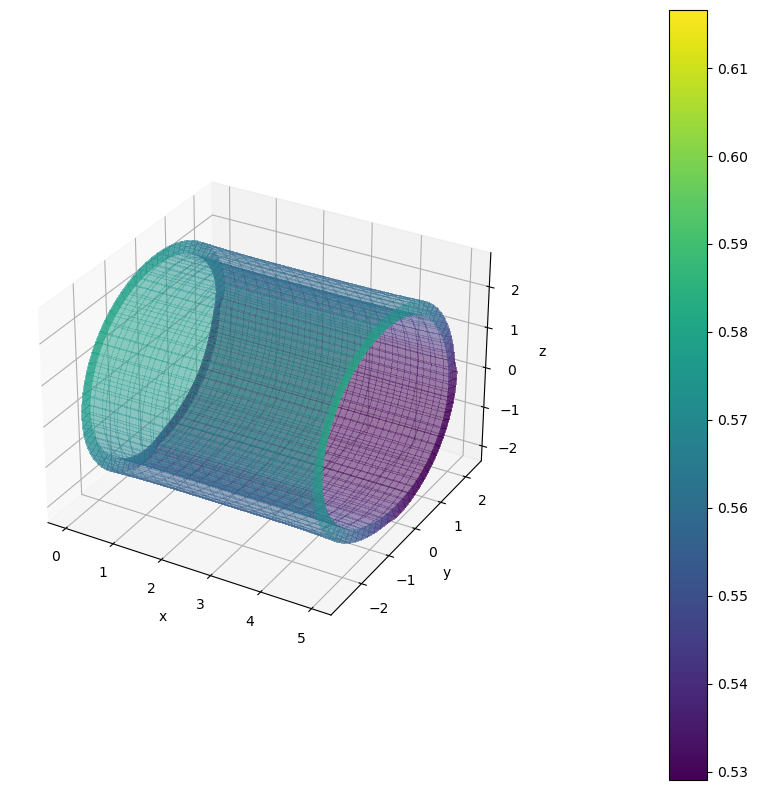

In [23]:
figsize(10,10)
fig = plt.figure()
ax = plt.axes(projection ='3d')
u1_funcs, u2_funcs, u3_funcs= split_u3d(u, MP_u, kvs_u, patches_u)
get_defplotU(u1_funcs, u2_funcs, u3_funcs, patches_u, kvs_u, MP_u)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.savefig('dir3d_1.png')
plt.show()

In [24]:
sum(iter_counts)

8


 patch: 0
displacement_inner= [[-4.33680869e-19  5.05467877e-02  6.42052812e-02]]
displacement_outer= [[0. 0. 0.]]
(20, 20, 1)
inner_radius:  1.9815872164615487
inner_radius:  1.9815872164615487
dis_inner_y/dis_outer_y:  inf
dis_inner_z/dis_outer_z:  inf

 patch: 1
displacement_inner= [[-1.51788304e-18 -6.42052812e-02 -5.05467877e-02]]
displacement_outer= [[0. 0. 0.]]
(20, 20, 1)
inner_radius:  1.981587216461549
inner_radius:  1.981587216461549
dis_inner_y/dis_outer_y:  -inf
dis_inner_z/dis_outer_z:  -inf

 patch: 2
displacement_inner= [[ 1.38777878e-17 -4.67846907e-01  1.56808699e-01]]
displacement_outer= [[ 5.55111512e-17 -4.34985468e-01  1.46060836e-01]]
(20, 20, 1)
inner_radius:  2.402968738334264
inner_radius:  2.402968738334264
dis_inner_y/dis_outer_y:  1.0755460625763744
dis_inner_z/dis_outer_z:  1.0735848359005287

 patch: 3
displacement_inner= [[ 5.89805982e-17 -1.56808699e-01  4.67846907e-01]]
displacement_outer= [[ 8.84708973e-17 -1.46060836e-01  4.34985468e-01]]
(20, 20, 1

C:\Users\MHeig\NUMAcloud\pyiga\notebooks\plots.py:865: RuntimeWarning: divide by zero encountered in scalar divide
  print( 'dis_inner_y/dis_outer_y: ', dis2[0,0,0]/dis2[0,res-1,0])
C:\Users\MHeig\NUMAcloud\pyiga\notebooks\plots.py:866: RuntimeWarning: divide by zero encountered in scalar divide
  print( 'dis_inner_z/dis_outer_z: ', dis3[0,0,0]/dis3[0,res-1,0])


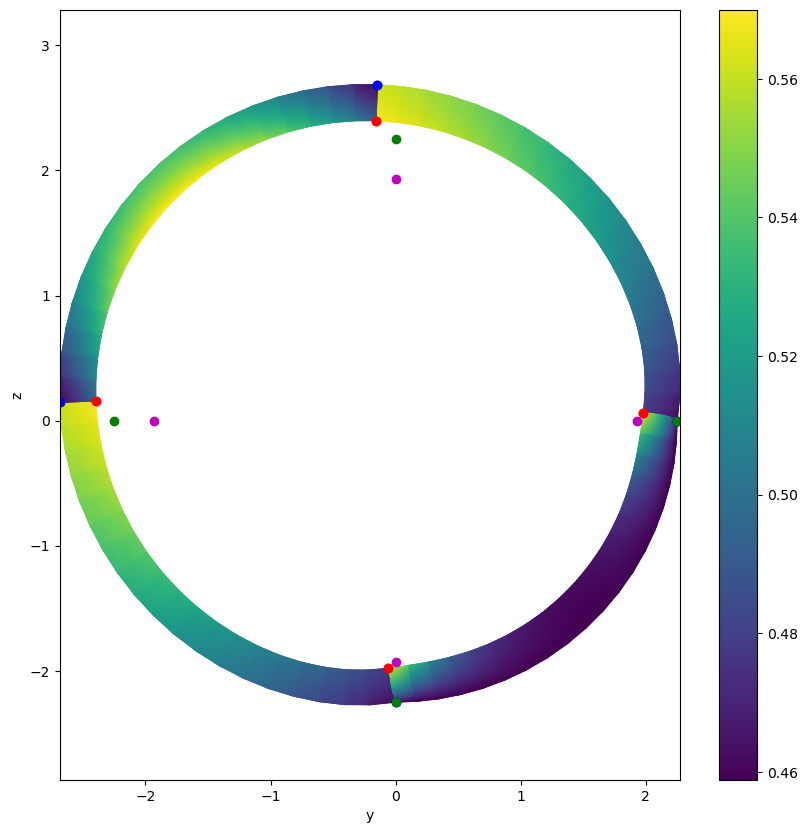

In [25]:
get_defplotpp3d(u, patches_u, kvs_u, MP_u, n_el)

In [26]:
vol_ratio= global_vol3d(u, MP_block, kvs_j)

In [27]:
cs = cauchystress3d(u, MP_block)
print(max(cs))

Compiling C:\Users\MHeig\AppData\Local\pyiga\pyiga\Cache\modules\mod56a88d7e0a89434a.pyx because it changed.
[1/1] Cythonizing C:\Users\MHeig\AppData\Local\pyiga\pyiga\Cache\modules\mod56a88d7e0a89434a.pyx
use SuperLU
0.4876511759135224


In [33]:
print(min(cs))

-0.27762809505801633


In [28]:
l_vol= local_vol3d(u, MP_block)

use SuperLU


In [42]:
# for scalar-valued input vector
def get_defplot_scalar3d(val,u, patches_u, kvs_u, MP_u, n_el, geos, arr, res=30):
    val_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ val)
               for p in range(len(patches_u))]

    u1_funcs, u2_funcs, u3_funcs = split_u3d(u, MP_u, kvs_u, patches_u)   
    
    # evaluate displacement (and "pressure") over a grid in the parameter domain
    # grid variables
    x_el = n_el[0]
    y_el = n_el[1]
    z_el = n_el[2]
    
    vrange= None
    fig, ax = plt.subplots(figsize= (10,10))
    
    # visualization per patch
    for (val_func,u1_func, u2_func, u3_func, (kvs, geo)) in zip(val_funcs, u1_funcs, u2_funcs, u3_funcs, patches_u): #u_funcs 
        gridz= 1
        supp = geo.support
        # if gridx/gridy is not an array, build an array with given number of ticks
        if np.isscalar(gridz):
            gridz = np.linspace(supp[2][1]/2, supp[2][1]/2, 1) # evaluate in the middle 

        meshx = np.linspace(supp[0][0], supp[0][1], res) # e.g. linespace(0, 1, 50)
        meshy = np.linspace(supp[1][0], supp[1][1], res)

        def plotlineC(pts, C, capstyle='butt'):
            #vrange = (C.min(), C.max())
            #vrange = (-0.3, 0.487)
            vrange = (arr.min(), arr.max())
            #vrange = (2e-4, 5.5e-4)

            plt.pcolormesh(pts[..., 1], pts[..., 2], C, shading='gouraud', cmap='viridis', vmin=vrange[0], vmax=vrange[1])


        zgridxy = (meshx, meshy, gridz)
        # z-grid
        vol = val_func.grid_eval(zgridxy) #x-value
        G= grid_eval(geo, zgridxy)
        C  = vol
        dis1 = u1_func.grid_eval(zgridxy) #x-value evaluated on 3-dim grid
        dis2 = u2_func.grid_eval(zgridxy) #y-value
        dis3 = u3_func.grid_eval(zgridxy) #z-value
        dis = np.stack((dis1,dis2, dis3), axis=-1) # displacement evaluated on 3-dim grid   

        pts = grid_eval(geo, zgridxy) + dis # # + displacement z-coord
        #pts = grid_eval(geo, zgridxy) # z-coord ## undeformed
        
        plotlineC(pts[:, :, 0],C[:, :, 0])
        for k in range(1, pts.shape[2] - 1): 
            plotlineC(pts[:, :, k], C[:, :, k])
        plotlineC(pts[:, :, -1], C[:, :, -1]) 

       #if vrange is None:
            #vrange = (C.min(), C.max())
        
        
    plt.colorbar();
    plt.axis('equal')
    ax.set_xlabel("y")
    ax.set_ylabel("z")
    plt.show()
    #plt.savefig('dir3d_cs.png')
 
    

use SuperLU


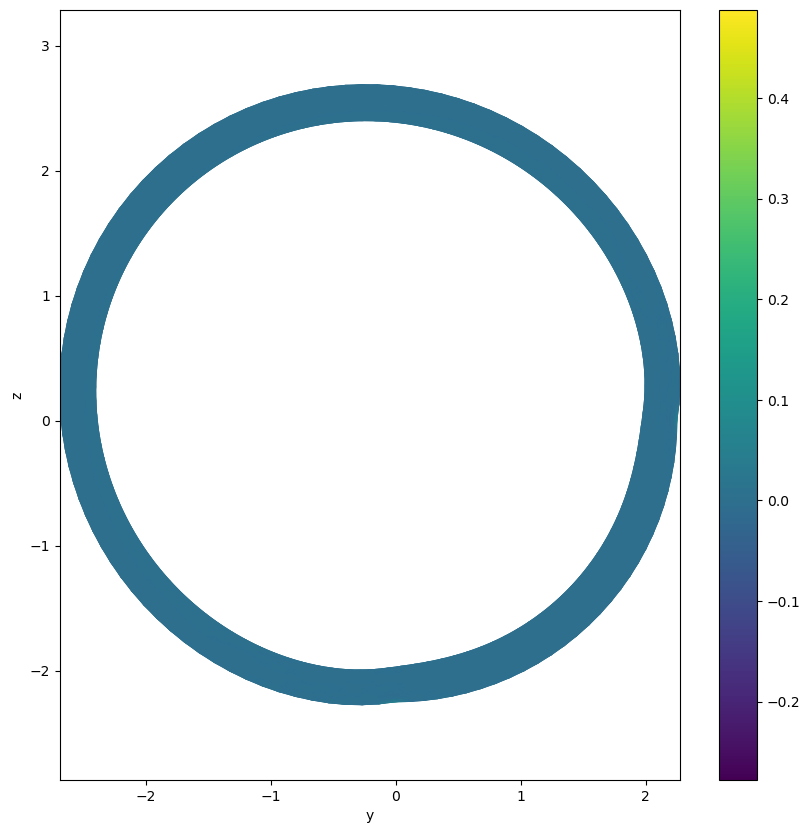

In [43]:
get_defplot_scalar3d(cauchystress3d(u, MP_block), u, patches_u, kvs_u, MP_u, n_el, geos, cs)

In [31]:
# for scalar-valued input vector
def get_defplot_scalar3d(val,u, patches_u, kvs_u, MP_u, n_el, geos, arr, res=30):
    val_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ val)
               for p in range(len(patches_u))]

    u1_funcs, u2_funcs, u3_funcs = split_u3d(u, MP_u, kvs_u, patches_u)   
    
    # evaluate displacement (and "pressure") over a grid in the parameter domain
    # grid variables
    x_el = n_el[0]
    y_el = n_el[1]
    z_el = n_el[2]
    
    vrange= None
    fig, ax = plt.subplots(figsize= (10,10))
    
    # visualization per patch
    for (val_func,u1_func, u2_func, u3_func, (kvs, geo)) in zip(val_funcs, u1_funcs, u2_funcs, u3_funcs, patches_u): #u_funcs 
        gridz= 1
        supp = geo.support
        # if gridx/gridy is not an array, build an array with given number of ticks
        if np.isscalar(gridz):
            gridz = np.linspace(supp[2][1]/2, supp[2][1]/2, 1) # evaluate in the middle 

        meshx = np.linspace(supp[0][0], supp[0][1], res) # e.g. linespace(0, 1, 50)
        meshy = np.linspace(supp[1][0], supp[1][1], res)

        def plotlineC(pts, C, capstyle='butt'):
            #vrange = (C.min(), C.max())
            #vrange = (-2.5e-4, 5.5e-4)
            vrange = (arr.min(), arr.max())
            #vrange = (2e-4, 5.5e-4)

            plt.pcolormesh(pts[..., 1], pts[..., 2], C, shading='gouraud', cmap='viridis', vmin=vrange[0], vmax=vrange[1])


        zgridxy = (meshx, meshy, gridz)
        # z-grid
        vol = val_func.grid_eval(zgridxy) #x-value
        G= grid_eval(geo, zgridxy)
        C  = vol
        dis1 = u1_func.grid_eval(zgridxy) #x-value evaluated on 3-dim grid
        dis2 = u2_func.grid_eval(zgridxy) #y-value
        dis3 = u3_func.grid_eval(zgridxy) #z-value
        dis = np.stack((dis1,dis2, dis3), axis=-1) # displacement evaluated on 3-dim grid   

        pts = grid_eval(geo, zgridxy) + dis # # + displacement z-coord
        #pts = grid_eval(geo, zgridxy) # z-coord ## undeformed
        
        plotlineC(pts[:, :, 0],C[:, :, 0])
        for k in range(1, pts.shape[2] - 1): 
            plotlineC(pts[:, :, k], C[:, :, k])
        plotlineC(pts[:, :, -1], C[:, :, -1]) 

       #if vrange is None:
            #vrange = (C.min(), C.max())
        
        
    plt.colorbar();
    plt.axis('equal')
    ax.set_xlabel("y")
    ax.set_ylabel("z")
    plt.show()
    plt.savefig('dir3d_vol.png')
 
    

use SuperLU


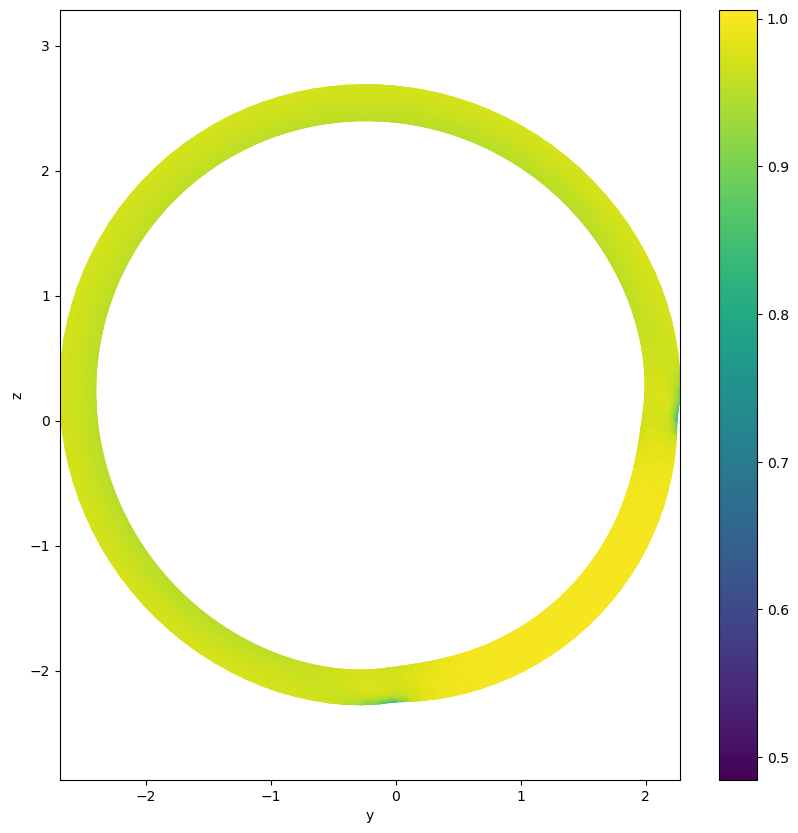

<Figure size 1000x1000 with 0 Axes>

In [32]:
# local volume
get_defplot_scalar3d(local_vol3d(u, MP_block), u, patches_u, kvs_u, MP_u, n_el, geos, l_vol)


 patch: 0
(0.0, 1.0)
grid z: [0.5]

 patch: 0
cauchystress_inner= [-0.00239673]
cauchystress_outer= [0.06727956]
volume_inner= [0.96018785]
volume_outer= [0.83306587]

 patch: 1

 patch: 2

 patch: 2
cauchystress_inner= [0.00044635]
cauchystress_outer= [0.00029399]
volume_inner= [0.95107034]
volume_outer= [0.9717074]

 patch: 3


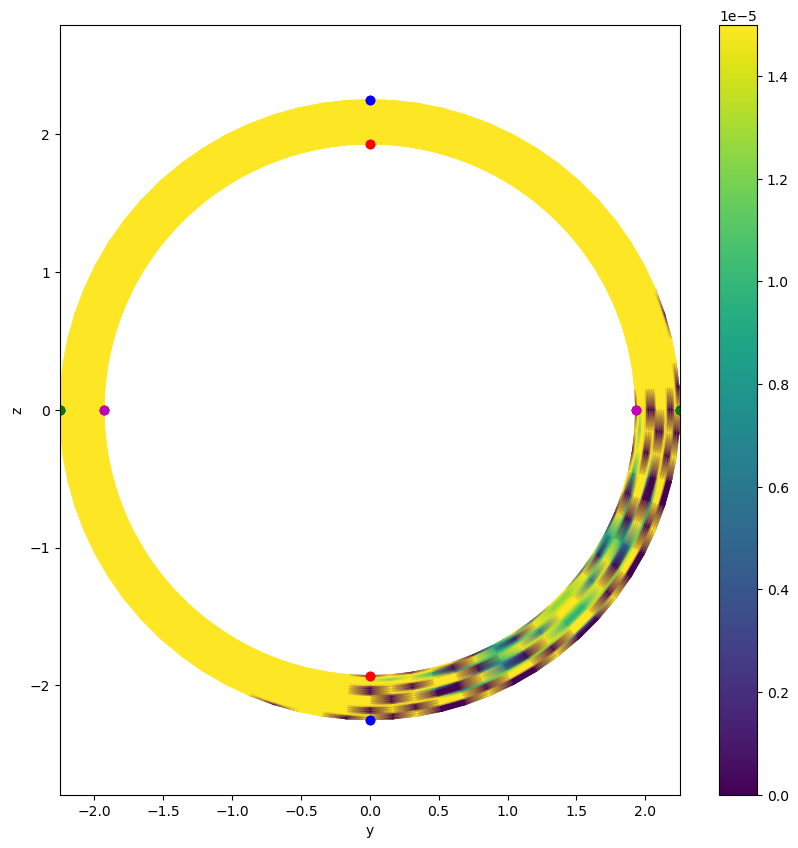

In [35]:
get_defplot_evalp3d(cauchystress3d(u, MP_block), local_vol3d(u, MP_block), patches_u, kvs_u, MP_u, n_el)

In [36]:
sum(iter_counts)

8

 
 
 1. loading: 0.0008886666666666666 

Residual = 0.004755109111853108
Energy   = 0.0
Error= 0.07830807299954114
1
Residual = 0.9255892072747742
Energy   = -0.0024341383633294618
Error= 0.02886267491178002
2
Residual = 0.00039599063299900936
Energy   = -0.0028572176035615727
Error= 0.004161081181602969
3
Residual = 0.0009595827955411452
Energy   = -0.002866144074471791
Error= 0.0009122194842196668
4
Residual = 4.222513147935465e-09
Energy   = -0.0028666687547260904
Error= 1.755364958151109e-05
5
Residual = 1.5555189856434467e-12
Energy   = -0.0028666950976485336
Error= 3.443481418110732e-08
6
Residual = 2.3228378754361992e-25
Energy   = -0.0028666951150424463
Error= 1.0532172030326554e-13
u=  [0.01979738 0.01182868 0.00628686 ... 0.05389773 0.05495805 0.05506034]
 
 
 2. loading: 0.0017773333333333335 

Residual = 0.004755109111863368
Energy   = -0.00843680259655848
Error= 0.07150200020354702
1
Residual = 0.3225218948108176
Energy   = -0.010702956350204108
Error= 0.01793592450306074


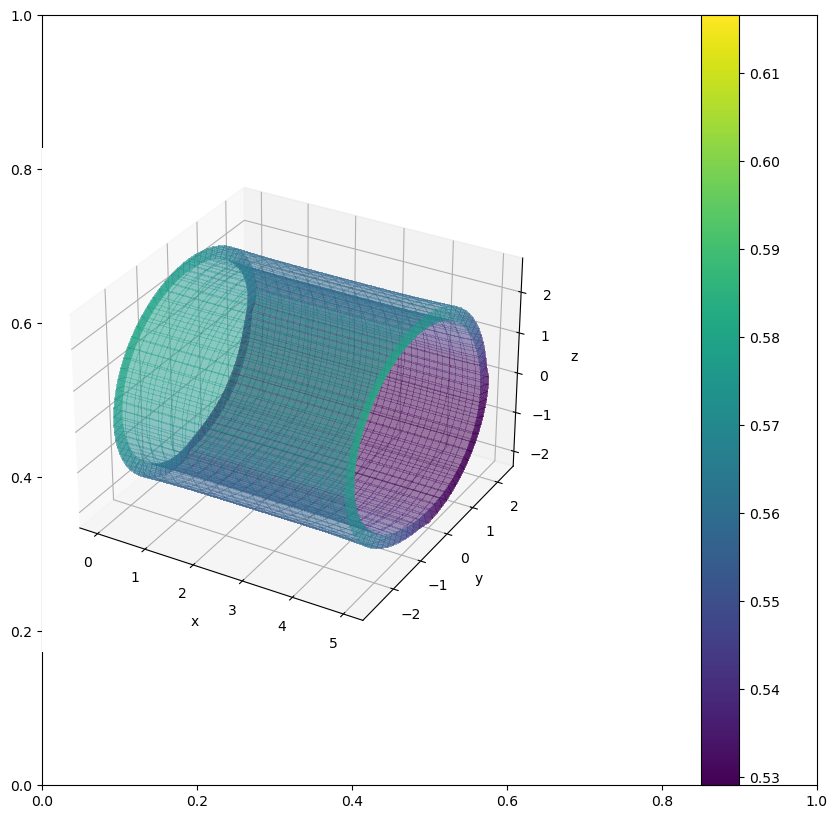

In [37]:
# solve linearized variational problem - iterative with full loading

#initial value
u= np.zeros(dd)

epsilon= 1e-4# 1e-5
max_err = 1e-11

solutions = []
stepsizes = [] 
ud_array = []
iter_counts = []


# incremental loading # ----------------------------------
for t in range(len(loading)): # time steps
    print(" \n \n {}. loading: {} \n".format(t+1,loading[t]))
    
    # set Neumann data via incremental loading
    l_val = loading[t]
    neu_data = [(0,'bottom',gN0, l_val), (1,'bottom',gN0, l_val), (2,'bottom',gN0, l_val), (3,'bottom',gN0, l_val)] # set neumann

    count = 0
    while True:

        A, b = ass_nonlinsystem3d(u, MP_block, neu_data)
        LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system
        rhs= LS.complete(LS.b)
        r = np.transpose(rhs).dot(Minv.dot(rhs)) #L2-norm
        print('Residual =',r)
        print('Energy   =',J(u))
            

        # # solve system # #
        #u_d = make_solver(A).dot(b) 
        u_d = make_solver(LS.A).dot(LS.b)
        u_d = LS.complete(u_d)
             
        w= np.inner(np.transpose(u_d),b)
        err = np.sqrt(np.abs(w))
        print('Error=', err)

        #----------------------------------------------------#
        ud_array.append(u_d)
        normed_du = np.transpose(u_d).dot(M.dot(u_d)) #L2-norm
        #normed_du = np.linalg.norm(u_d)/np.sqrt(len(u_d))
        stepsize_du = normed_du # times alpha
        stepsizes.append(stepsize_du)
        #---------------------------------------------------#

        #if r < epsilon * r0: # break condition
        if err < max_err:
            break
        elif count == 20:
            break
            
        # update solution
        u += u_d 
        count+=1
        print(count)
        
    #
    ud_array.append(u_d) 
    print('u= ' , u)
    solutions.append(LS.restrict(u))
    iter_counts.append(count)
        
# print deformation plot (after first iteration)
get_defplotC(u, patches_u, kvs_u, MP_u)

In [38]:
s_sol= shape(solutions)[0]

In [39]:
"""Visualization functions."""
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.collections import LineCollection


def animate_field_3d(fields, patches_u, kvs_u, vrange=None, res=50,cmap=None, interval=50, progress=False):
    """Animate a sequence of scalar fields over a geometry."""
    
    figsize(10,10)
    fig = plt.figure()
    ax = plt.axes(projection ='3d') #,xlim=(0, 2), ylim=(-0.5, 0.5)
    
    fields = list(fields)
    ar= np.linspace(1,20, s_sol)
    factor = 1 #ar[0]
    vrange = None
    
    # first solution
    u= LS.complete(fields[0])
    
    #Split solution vector into displacement components
    u1 = u[:MP_u.numdofs] 
    u2 = u[MP_u.numdofs:2*MP_u.numdofs]
    u3 = u[2*MP_u.numdofs:3*MP_u.numdofs]
   
    # restrict solution to each individual patch - BSpline functions
    u1_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u1)
           for p in range(len(patches_u))]
    u2_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u2)
           for p in range(len(patches_u))]
    u3_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u3)
           for p in range(len(patches_u))]
    
    def plotlineC(pts, C, capstyle='butt'):
                vrange = (C.min(), C.max())
                norm = mpl.colors.Normalize(vmin=vrange[0], vmax=vrange[1])
                ax.plot_surface(pts[..., 0], pts[..., 1], pts[..., 2], linewidth=0, antialiased=False, shade = False, alpha = 0.3,facecolors=cm.viridis(C), vmin=vrange[0], vmax=vrange[1])

            #ax.plot_wireframe(pts[..., 0], pts[..., 1], pts[..., 2], linewidth=1, color='grey') # grid
            #ax.plot_surface(pts[..., 0], pts[..., 1], pts[..., 2], facecolors=colors, linewidth=0) # checkerboard
            
    
     # visualization per patch
    for (u1_func, u2_func, u3_func, (kvs, geo)) in zip(u1_funcs, u2_funcs, u3_funcs, patches_u): #u_funcs 
        supp = geo.support
        
        gridx = np.linspace(supp[0][0], supp[0][1], 2) # e.g. linespace(0, 1, 2)
        gridy = np.linspace(supp[1][0], supp[1][1], 2)
        gridz = np.linspace(supp[2][0], supp[2][1], 2)

        meshx = np.linspace(supp[0][0], supp[0][1], res) # e.g. linespace(0, 1, 50)
        meshy = np.linspace(supp[1][0], supp[1][1], res)
        meshz = np.linspace(supp[2][0], supp[2][1], res)
        
        ygridxz = (meshx, gridy, meshz)
        zgridxy = (meshx, meshy, gridz)
        
        # y-grid 
        dis1 = u1_func.grid_eval(ygridxz) #x-value evaluated on 3-dim grid
        dis2 = u2_func.grid_eval(ygridxz) #y-value
        dis3 = u3_func.grid_eval(ygridxz) #z-value
        dis = np.stack((dis1,dis2, dis3), axis=-1) # displacement evaluated on 3-dim grid
      
        #C = np.sqrt(np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))
        #vrange = (C.min(), C.max())
        
        pts = grid_eval(geo, ygridxz) + dis  # + displacement y-coord
        #C = np.sqrt(np.power(dis[..., 0], 2)+ np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))
        C = np.sqrt(np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))
        plotlineC(pts[:, 0, :], C[:, 0, :])
        for j in range(1, pts.shape[1] - 1):
            plotlineC(pts[:, j, :], C[:, j, :])
        plotlineC(pts[:, -1, :], C[:, -1, :])
        
        
        
        ##'''
        # z-grid
        dis1 = u1_func.grid_eval(zgridxy) #x-value evaluated on 3-dim grid
        dis2 = u2_func.grid_eval(zgridxy) #y-value
        dis3 = u3_func.grid_eval(zgridxy) #z-value
        dis = np.stack((dis1,dis2, dis3), axis=-1) # displacement evaluated on 3-dim grid  
        
        #vrange = (C.min(), np.amax(dis[0, 0,...]))

        pts = grid_eval(geo, zgridxy) + dis # # + displacement z-coord
        C = np.sqrt(np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))
        #C = np.sqrt(np.power(dis[..., 0], 2)+ np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))
        plotlineC(pts[:, :, 0],C[:, :, 0])
        for k in range(1, pts.shape[2] - 1): 
            plotlineC(pts[:, :, k], C[:, :, k])
        plotlineC(pts[:, :, -1], C[:, :, -1])
        
    vrange = (C.min(), np.amax(dis[0, 0,...]))
    norm = mpl.colors.Normalize(vmin=vrange[0], vmax=vrange[1])   
    cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='viridis'), ax=ax, pad=0.2)
    #plt.show()
  
    #fig.colorbar(quadmesh, ax=ax);
    #colorbar();
    tqdm = vis.utils.progress_bar(progress)
    pbar = tqdm(total=len(fields))
    
    ax.set_xlim3d(left=0, right=5.5)
    ax.set_ylim3d(bottom=-7, top=4.5)
    #ax.set_zlim3d(bottom=-0.5, top=0.5)
    ax.set_zbound(lower=-5.5, upper=5.5)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    
    
    def anim_func(i):
        plt.cla()
        
        vrange= None
        #factor = ar[i] # choose factor for deformation plot
        #u= fields[i]
        u = LS.complete(fields[i])

        #Split solution vector into displacement components
        u1 = u[:MP_u.numdofs] 
        u2 = u[MP_u.numdofs:2*MP_u.numdofs]
        u3 = u[2*MP_u.numdofs:3*MP_u.numdofs]

        # restrict solution to each individual patch - BSpline functions
        u1_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u1)
               for p in range(len(patches_u))]
        u2_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u2)
               for p in range(len(patches_u))]
        u3_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u3)
               for p in range(len(patches_u))]
        
             # visualization per patch
        for (u1_func, u2_func, u3_func, (kvs, geo)) in zip(u1_funcs, u2_funcs, u3_funcs, patches_u): #u_funcs 

            # y-grid 
            dis1 = u1_func.grid_eval(ygridxz) #x-value evaluated on 3-dim grid
            dis2 = u2_func.grid_eval(ygridxz) #y-value
            dis3 = u3_func.grid_eval(ygridxz) #z-value
            dis = np.stack((dis1,dis2, dis3), axis=-1) # displacement evaluated on 3-dim grid
            #print('displacement_inner= {}'.format(dis[0, 0,...]))
            print( 'max_val: ', np.amax(dis[0, 0,...]))
            
            

            pts = grid_eval(geo, ygridxz) + dis  # + displacement y-coord
            #C = np.sqrt(np.power(dis[..., 0], 2)+ np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))
            C = np.sqrt(np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))
            plotlineC(pts[:, 0, :], C[:, 0, :])
            for j in range(1, pts.shape[1] - 1):
                plotlineC(pts[:, j, :], C[:, j, :])
            plotlineC(pts[:, -1, :], C[:, -1, :])

            # z-grid
            dis1 = u1_func.grid_eval(zgridxy) #x-value evaluated on 3-dim grid
            dis2 = u2_func.grid_eval(zgridxy) #y-value
            dis3 = u3_func.grid_eval(zgridxy) #z-value
            dis = np.stack((dis1,dis2, dis3), axis=-1) # displacement evaluated on 3-dim grid   

            #C = np.sqrt(np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))
            #vrange = (C.min(), C.max())
            #norm = mpl.colors.Normalize(vmin=vrange[0], vmax=vrange[1])

            pts = grid_eval(geo, zgridxy) + dis # # + displacement z-coord
            C = np.sqrt(np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))
            
            #C = np.sqrt(np.power(dis[..., 0], 2)+ np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))
            plotlineC(pts[:, :, 0],C[:, :, 0])
            for k in range(1, pts.shape[2] - 1): 
                plotlineC(pts[:, :, k], C[:, :, k])
            plotlineC(pts[:, :, -1], C[:, :, -1])
        
        pbar.update()
        if i == len(u) - 1:
            pbar.close()

            #
    #vrange = (C.min(), np.amax(dis[0, 0,...]))
    #norm = mpl.colors.Normalize(vmin=vrange[0], vmax=vrange[1])
    #cbar=plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='viridis'), ax=ax, pad=0.2)
    
    
    return animation.FuncAnimation(plt.gcf(), anim_func, frames=len(fields), interval=interval, repeat=False)
    


  0%|                                                                                                                                 | 0/3 [00:00<?, ?it/s]

max_val:  0.03616598176517742
max_val:  0.016475725877129727


 33%|████████████████████████████████████████▎                                                                                | 1/3 [00:00<00:00,  2.08it/s]

max_val:  0.06735372966646656
max_val:  0.187797720091787
max_val:  0.03616598176517742
max_val:  0.016475725877129727
max_val:  0.06735372966646656
max_val:  0.187797720091787


 67%|████████████████████████████████████████████████████████████████████████████████▋                                        | 2/3 [00:01<00:00,  1.76it/s]

max_val:  0.06377003306914189
max_val:  0.029512692471617637
max_val:  0.12597041343732274


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.34s/it]

max_val:  0.353094450868621
max_val:  0.08631721464207005
max_val:  0.0400442146434659
max_val:  0.17788592988195098


4it [00:05,  1.55s/it]                                                                                                                                      

max_val:  0.5020632903261822


4it [00:06,  1.71s/it]


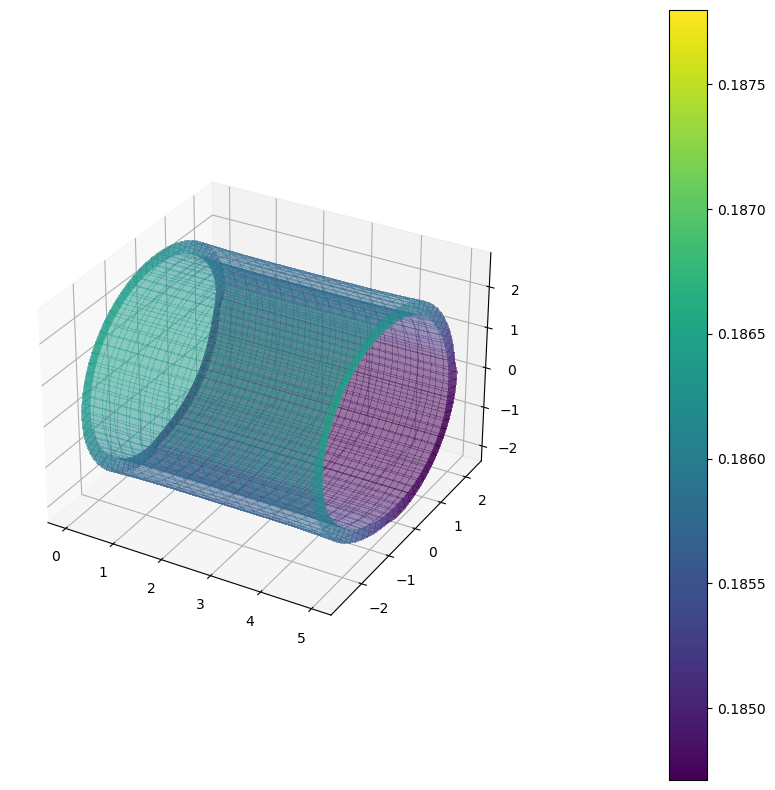

In [40]:
from IPython.display import HTML

s_sol= shape(solutions)[0]

figsize(14, 4)
#fields = [ud_array[tt] for tt in range(s_sol)]
fields = [solutions[tt] for tt in range(s_sol)] ## time steps
HTML(animate_field_3d(fields, patches_u, kvs_u, res=20, interval=535, progress=True).to_html5_video())
#writervideo = animation.FFMpegWriter(fps=600)
#HTML(animate_field_3d(fields, patches_u, kvs_u, res=20, interval=600, progress=True).save('Dir3d06.mp4', writer=writervideo))

In [41]:
vol_ratio= global_vol3d(u, MP_block, kvs_j)

In [42]:
vol_ratio

0.24092487555189732

 
 
 max. loading: 0.002666 

Residual = 0.042795982006677974
Energy   = 0.0
Error= 0.2349242189986234
1
Residual = 67.89692237528361
Energy   = 0.010577056726789538
Error= 0.2521282367861235
2
Residual = 0.5600888686497378
Energy   = -0.022414706042946424
Error= 0.03828060197851698
3
Residual = 0.16188214984088606
Energy   = -0.023177922623572923
Error= 0.01568207938760807
4
Residual = 0.004261317922348726
Energy   = -0.023314296585088358
Error= 0.004466547891994177
5
Residual = 0.0004574448786290869
Energy   = -0.023331087566566724
Error= 0.0007759009050500916
6
Residual = 4.789022279094232e-07
Energy   = -0.02333338116420181
Error= 6.482468553043678e-05
7
Residual = 1.3091939733245905e-09
Energy   = -0.0233339877671566
Error= 1.0711851724829286e-06
8
Residual = 1.0496658885227518e-17
Energy   = -0.023333993073444186
Error= 2.799863013050482e-10
9
Residual = 7.425378453434846e-27
Energy   = -0.023333993076256172
Error= 1.40975971207249e-15
u=  [0.04868518 0.02970279 0.01642976 ... 0.

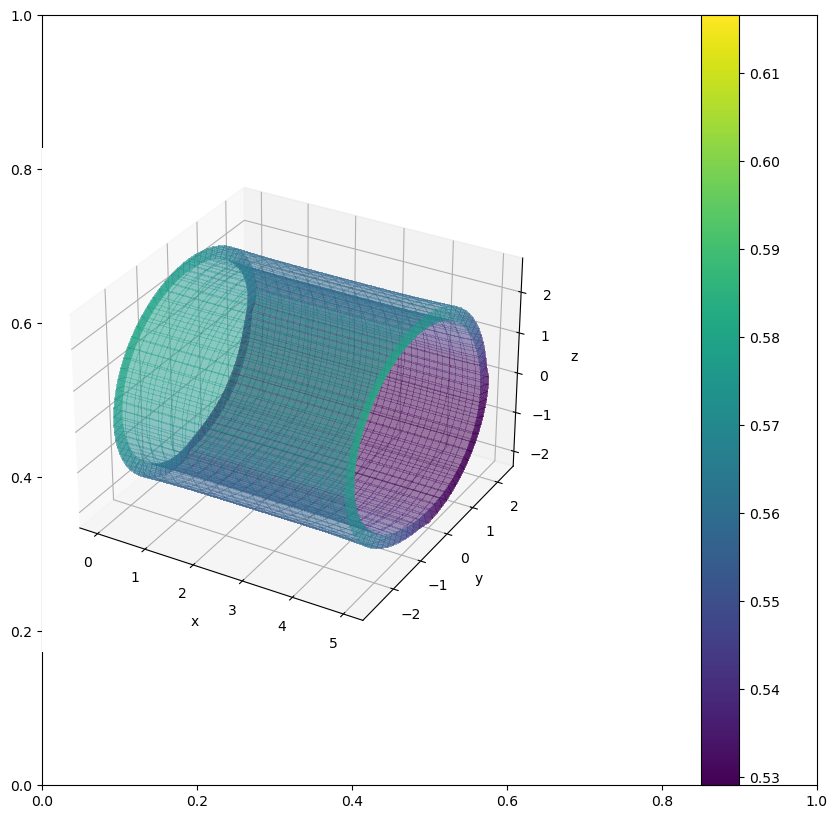

In [43]:
# solve linearized variational problem - iterative, without line-search

#initial value
u= np.zeros(dd)

max_err = 1e-11

solutions = []
stepsizes = [] 
ud_array = []
iter_counts = []

# without incremental loading
print(" \n \n max. loading: {} \n".format(loading[-1]))

# set Neumann data 
l_val = loading[-1]
neu_data = [(0,'bottom',gN0, l_val), (1,'bottom',gN0, l_val), (2,'bottom',gN0, l_val), (3,'bottom',gN0, l_val)] # set neumann

count = 0

while True:
    A, b = ass_nonlinsystem3d(u, MP_block, neu_data)
    LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system
    rhs= LS.complete(LS.b)
    r = np.transpose(rhs).dot(Minv.dot(rhs)) #L2-norm
    print('Residual =',r)
    print('Energy   =',J(u))
    
    # # solve system # #
    #u_d = make_solver(A).dot(b) 
    u_d = make_solver(LS.A).dot(LS.b)
    u_d = LS.complete(u_d)
    
    w= np.inner(np.transpose(u_d),rhs)
    err = np.sqrt(np.abs(w))
    print('Error=', err)
    
    if abs(err) < max_err:
        break
    elif count == 30:
        break
    
    count+=1
    print(count)
    # update solution
    u += u_d   
    
    #----------------------------------------------------#
    ud_array.append(u_d)
    normed_du = np.transpose(u_d).dot(M.dot(u_d)) #L2-norm
    #normed_du = np.linalg.norm(u_d)/np.sqrt(len(u_d))
    stepsize_du = normed_du # times alpha
    stepsizes.append(stepsize_du)
    #iter_counts.append(count)
    #---------------------------------------------------#

ud_array.append(u_d) 
print('u= ' , u)
solutions.append(LS.restrict(u))
iter_counts.append(count)
        
# print deformation plot (after first iteration)
get_defplotC(u, patches_u, kvs_u, MP_u)

In [44]:
sum(iter_counts)

9

 
 
 1. loading: 0.0008886666666666666 

Residual = 0.004755109111853108
Energy   = 0.0
Error= 0.07830807299954114
1
Residual = 0.9255892072747677
Energy   = -0.0024341383633294635
Error= 0.028862674911780035
2
Residual = 0.00039599063299903127
Energy   = -0.0028572176035615723
Error= 0.004161081181602939
3
Residual = 0.0009595827955411111
Energy   = -0.0028661440744717913
Error= 0.000912219484219656
4
Residual = 4.222513147920713e-09
Energy   = -0.002866668754726089
Error= 1.7553649581548896e-05
5
Residual = 1.5555189820571326e-12
Energy   = -0.0028666950976485336
Error= 3.443481417693548e-08
6
Residual = 2.3432900340540196e-25
Energy   = -0.0028666951150424463
Error= 1.0532260647664221e-13
u=  [0.01979738 0.01182868 0.00628686 ... 0.05389773 0.05495805 0.05506034]
 
 
 2. loading: 0.0017773333333333335 

Residual = 0.004755109111863009
Energy   = -0.00843680259655848
Error= 0.07150200020354831
1
Residual = 0.3225218948108438
Energy   = -0.01070295635020407
Error= 0.017935924503062122

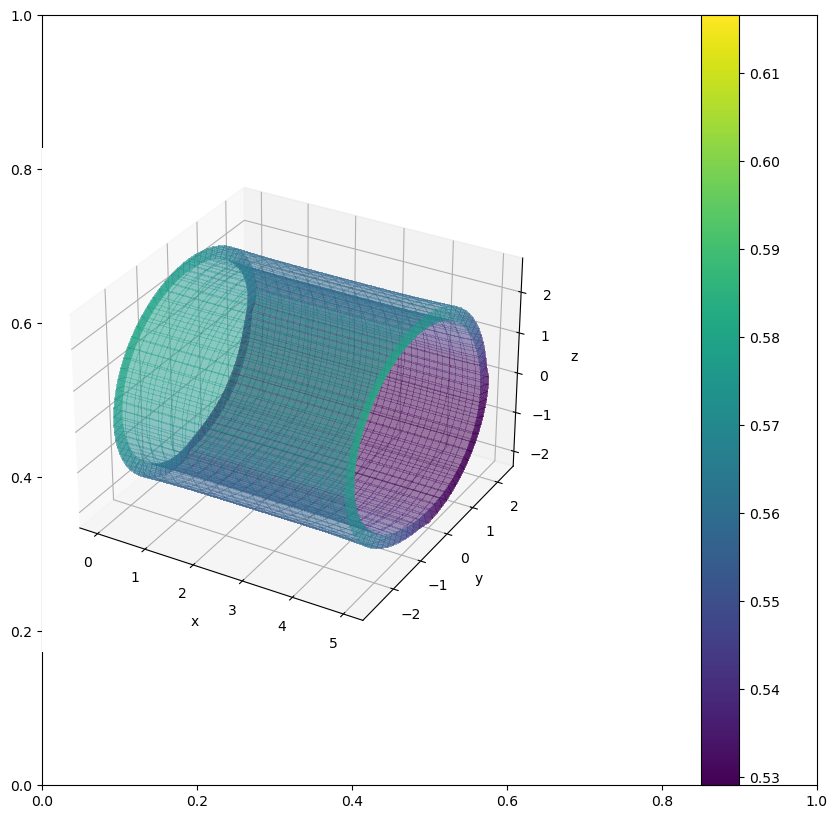

In [45]:
# solve linearized variational problem - iterative with full loading

#initial value
u= np.zeros(dd)

epsilon= 1e-4# 1e-5
max_err = 1e-11

solutions = []
stepsizes = [] 
ud_array = []
iter_counts = []


# incremental loading # ----------------------------------
for t in range(len(loading)): # time steps
    print(" \n \n {}. loading: {} \n".format(t+1,loading[t]))
    
    # set Neumann data via incremental loading
    l_val = loading[t]
    neu_data = [(0,'bottom',gN0, l_val), (1,'bottom',gN0, l_val), (2,'bottom',gN0, l_val), (3,'bottom',gN0, l_val)] # set neumann

    count = 0
    while True:

        A, b = ass_nonlinsystem3d(u, MP_block, neu_data)
        LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system
        rhs= LS.complete(LS.b)
        r = np.transpose(rhs).dot(Minv.dot(rhs)) #L2-norm
        print('Residual =',r)
        print('Energy   =',J(u))
            

        # # solve system # #
        #u_d = make_solver(A).dot(b) 
        u_d = make_solver(LS.A).dot(LS.b)
        u_d = LS.complete(u_d)
             
        w= np.inner(np.transpose(u_d),b)
        err = np.sqrt(np.abs(w))
        print('Error=', err)

        #----------------------------------------------------#
        ud_array.append(u_d)
        normed_du = np.transpose(u_d).dot(M.dot(u_d)) #L2-norm
        #normed_du = np.linalg.norm(u_d)/np.sqrt(len(u_d))
        stepsize_du = normed_du # times alpha
        stepsizes.append(stepsize_du)
        #---------------------------------------------------#

        #if r < epsilon * r0: # break condition
        if err < max_err:
            break
        elif count == 20:
            break
            
        # update solution
        u += u_d 
        count+=1
        print(count)
        
    #
    ud_array.append(u_d) 
    print('u= ' , u)
    solutions.append(LS.restrict(u))
    iter_counts.append(count)
        
# print deformation plot (after first iteration)
get_defplotC(u, patches_u, kvs_u, MP_u)